In [1]:
import sympy as sy
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import utilitis_FEEC.Bspline               as bspline
import utilitis_FEEC.bsplines              as bsp
import utilitis_FEEC.derivatives           as der
import utilitis_FEEC.spline_mappings_polar as splmap
import utilitis_FEEC.evaluation            as eva
import utilitis_FEEC.mass_matrices         as mass

In [3]:
Nel = [32, 64]           # mesh generation on logical domain
bc  = [False, True]    # boundary conditions
p   = [3, 3]           # spline degrees  

el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta     = [1/Nel for Nel in Nel]                                             # element sizes
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors         (discrete mapping)
t         = [T[1:-1] for T in T]                                               # reduced knot vectors (discrete mapping)
NbaseN    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (discrete mapping)


# polar region
T_pole      = [T[0], np.repeat(T[1], 4)[9:-9]]
p_pole      = [p[0], 2*p[1]]
NbaseN_pole = [NbaseN[0], len(T_pole[1]) - p_pole[1] - 1 - p[1]]

(-1.114779191413642, 1.11546850281434, -1.1151238471139913, 1.1151238471139908)

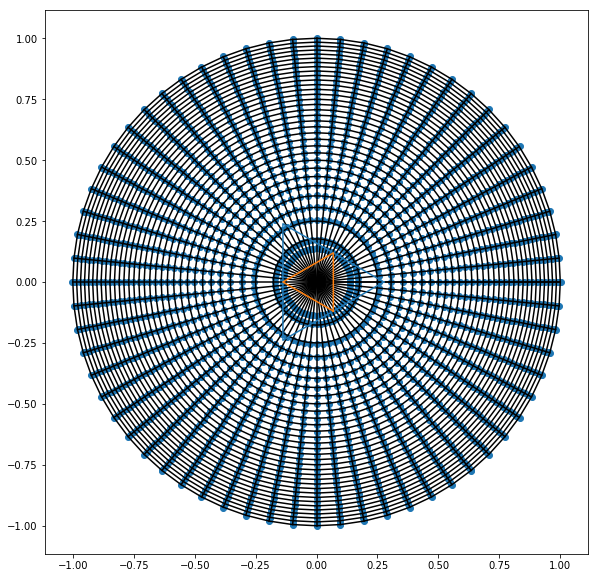

In [4]:
geometry = 'square root polar'

spline_map = splmap.discrete_mapping_2d(T, p, bc, geometry)

qplot = [np.linspace(0., 1., Nel[0] + 1), np.linspace(0., 1., Nel[1] + 1)]
xplot, yplot = spline_map.mapping(qplot)
tau, lam = spline_map.barycentric_coordinates(1)


# coordinates of control triangle
Tx = np.array([tau, -tau/2, -tau/2, tau])
Ty = np.array([0., np.sqrt(3)/2*tau, -np.sqrt(3)/2*tau, 0.])

tx = np.array([tau/4, tau/4, -tau/2, tau/4])
ty = np.array([-np.sqrt(3)/4*tau, np.sqrt(3)/4*tau, 0., -np.sqrt(3)/4*tau])

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)


for i in range(len(qplot[0])):
    plt.plot(xplot[i, :], yplot[i, :], 'k')
    
for i in range(len(qplot[1])):
    plt.plot(xplot[:, i], yplot[:, i], 'k')
    
plt.scatter(spline_map.c[0].flatten(), spline_map.c[1].flatten())

plt.plot(Tx, Ty)
plt.plot(tx, ty)

plt.axis('square')

# 1. Test C1 polar splines

In [109]:
# get extraction operator
E, tau = spline_map.C1_coefficients()

In [110]:
# evaluate tensor basis
qplot = [np.linspace(0., 1., 500), np.linspace(0., 1., 500)]

N     = [sp.sparse.csr_matrix(bsp.collocation_matrix(T, p, qplot, bc)) for T, p, qplot, bc in zip(T, p, qplot, bc)]
N     =  sp.sparse.kron(N[0], N[1])

basis = E.dot(N.T)

(-0.8999861174007647,
 1.7000009909507172,
 -1.299993554175741,
 1.299993554175741)

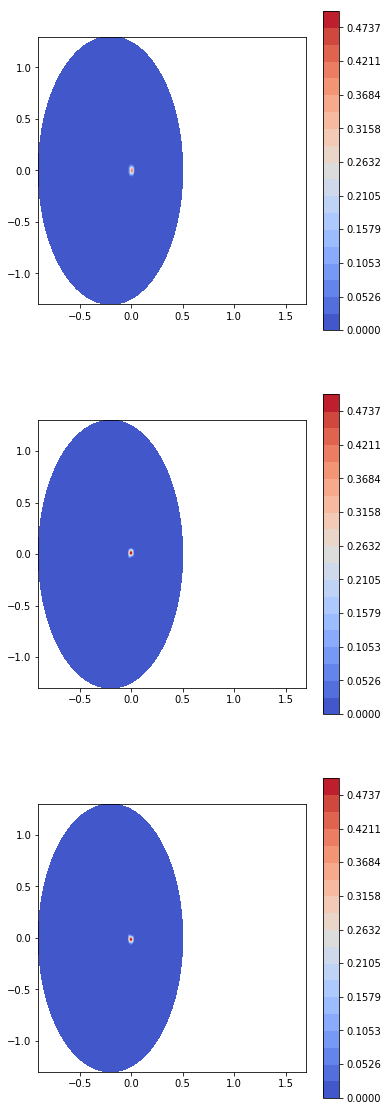

In [111]:
# plot three new basis functions at pole
fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(20)

X, Y = spline_map.mapping(qplot)

plt.subplot(3, 1, 1)
plt.contourf(X, Y, basis[0].toarray().reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.5, 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

plt.subplot(3, 1, 2)
plt.contourf(X, Y, basis[1].toarray().reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.5, 20))
#plt.xlim((-0.2, 0.2))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

plt.subplot(3, 1, 3)
plt.contourf(X, Y, basis[2].toarray().reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.5, 20))
#plt.xlim((-0.2, 0.2))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

In [112]:
# ... coordinates
s, phi = sy.symbols('s, phi')
q      = sy.Matrix([s, phi])

# ... mapping
x0    = 0.
y0    = 0.
kappa = 0.3
delta = 0.2


#F = sy.Matrix([x0 + s*sy.cos(2*sy.pi*phi), y0 + s*sy.sin(2*sy.pi*phi)])
#F = sy.Matrix([x0 + sy.sqrt(s)*sy.cos(2*sy.pi*phi), y0 + sy.sqrt(s)*sy.sin(2*sy.pi*phi)])
F = sy.Matrix([x0 + (1 - kappa)*s*sy.cos(2*sy.pi*phi) - delta*s**2, y0 + (1 + kappa)*s*sy.sin(2*sy.pi*phi)])
# ...

# ... jacobian matrix and its inverse
DF    = sy.simplify(F.jacobian(q))
DFinv = DF.inverse()

# ... metric tensor and its inverse
G    = sy.simplify(DF.transpose()*DF)
Ginv = G.inverse()

#... square root of jacobi determinant
g      = sy.simplify(G.det())
g_sqrt = sy.sqrt(g)

In [113]:
# ... create model with method of manufactured solutions
#phi0     = (1 - s**2)*sy.cos(2*sy.pi*F[0])*sy.sin(2*sy.pi*F[1] + sy.pi/2)
phi0     = (1 - s**2)*sy.cos(2*sy.pi*F[0])*sy.sin(2*sy.pi*F[1])

dphi0    = sy.Matrix([sy.diff(phi0, s), sy.diff(phi0, phi)])
temp     = g_sqrt*Ginv*dphi0

n2       = -(sy.diff(temp[0], s) + sy.diff(temp[1], phi))
hodge_n2 = 1/g_sqrt*n2


phi0     = sy.lambdify(q, phi0)
hodge_n2 = sy.lambdify(q, hodge_n2)

# ... convert mapping functions to callables
xc = sy.lambdify(q, F[0])
yc = sy.lambdify(q, F[1])

G      = [[sy.lambdify(q, G[0, 0])   , sy.lambdify(q, G[0, 1])]   , [sy.lambdify(q, G[1, 0])   , sy.lambdify(q, G[1, 1])]]
Ginv   = [[sy.lambdify(q, Ginv[0, 0]), sy.lambdify(q, Ginv[0, 1])], [sy.lambdify(q, Ginv[1, 0]), sy.lambdify(q, Ginv[1, 1])]]
g      = sy.lambdify(q, g)
g_sqrt = sy.lambdify(q, g_sqrt)

(-0.8999861271636242,
 1.7000009908849716,
 -1.299993559024298,
 1.299993559024298)

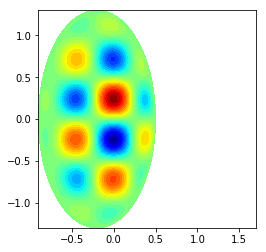

In [114]:
Q1plot, Q2plot = np.meshgrid(qplot[0], qplot[1], indexing='ij')

X, Y = xc(Q1plot, Q2plot), yc(Q1plot, Q2plot)

plt.contourf(X, Y, phi0(Q1plot, Q2plot), cmap='jet', levels=np.linspace(-1., 1., 30))
plt.axis('square')

(-0.8999861174007647,
 1.7000009909507172,
 -1.299993554175741,
 1.299993554175741)

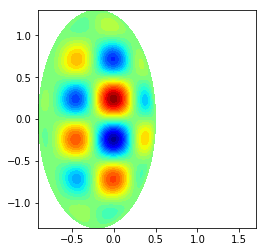

In [115]:
# test L2-projection in V0
M0 = mass.mass_V0_2d(T, p, bc, geometry)
F0 = mass.inner_prod_V0_2d(T, p, bc, geometry, phi0)

result = sp.sparse.linalg.spsolve(E.dot(M0).dot(E.T), E.dot(F0.flatten()))
result = E.T.dot(result)

test = eva.FEM_field_V0_2d(result, qplot, T, p, bc).reshape(len(qplot[0]), len(qplot[1]))

X, Y = spline_map.mapping(qplot)
plt.contourf(X, Y, test, cmap='jet', levels=np.linspace(-1., 1., 30))
plt.axis('square')

/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


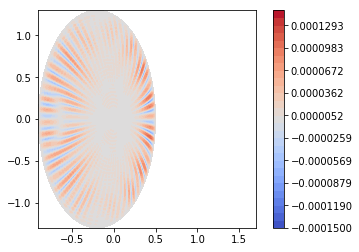

In [122]:
# test Poisson 

# discrete gradient matrix
DER  = der.discrete_derivatives(T, p, bc)
GRAD = DER.GRAD_2d()

# mass matrix in H(curl)
M1 = mass.mass_V1_2d_curl(T, p, bc, geometry)

# right-hand side in H1
RHS = mass.inner_prod_V0_2d(T, p, bc, geometry, hodge_n2)

# C1 smoothness constraint
LHS = E.dot(GRAD.T).dot(M1).dot(GRAD).dot(E.T)
RHS = E.dot(RHS.flatten())

# Dirichlet boundary conditions at outer boundary (last NbaseN[1] entries)
LHS[-NbaseN[1]:, :] = 0.
LHS[:, -NbaseN[1]:] = 0.
LHS[-NbaseN[1]:, -NbaseN[1]:] = np.identity(NbaseN[1])
RHS[-NbaseN[1]:] = 0.

# solve system and pull back on tensor product space
result = E.T.dot(sp.sparse.linalg.spsolve(LHS, RHS))

test = eva.FEM_field_V0_2d(result, qplot, T, p, bc).reshape(len(qplot[0]), len(qplot[1]))

X, Y = spline_map.mapping(qplot)
plt.contourf(X, Y, test - phi0(Q1plot, Q2plot), cmap='coolwarm', levels=np.linspace(-1.5e-4, 1.5e-4, 30))
plt.axis('square')
plt.colorbar()

In [124]:
# L2 error
error = mass.L2_error_V0_2d(result.reshape(NbaseN[0], NbaseN[1]), T, p, bc, geometry, phi0)

In [120]:
error

3.910252727513547e-05

In [56]:
error

2.0318551329795354e-06

In [126]:
# L infinity norm
GREV1, GREV2 = np.meshgrid(spline_map.greville[0], spline_map.greville[1], indexing='ij')

error = np.abs(eva.FEM_field_V0_2d(result, [spline_map.greville[0], spline_map.greville[1]], T, p, bc) - phi0(GREV1, GREV2).flatten()).max()

In [127]:
error

0.00011402869758408984

In [104]:
er*10**6

6.418929474949486

# 2. Test C2 polar splines

In [278]:
# plot 6 new basis functions on physical domain
qplot = np.linspace(0., 1., 100), np.linspace(0., 1., 100)

Q1plot, Q2plot = np.meshgrid(qplot[0], qplot[1], indexing='ij')

# evaluate tensor basis
N1 = np.zeros((len(qplot[0]), NbaseN_pole[0]))
N2 = np.zeros((len(qplot[1]), NbaseN_pole[1]))

for i in range(len(qplot[1])):
    
    span1  = bsp.find_span(T_pole[0], p_pole[0], qplot[0][i])
    span2  = bsp.find_span(T_pole[1], p_pole[1], qplot[1][i])
    
    basis1 = bsp.basis_funs(T_pole[0], p_pole[0], qplot[0][i], span1)
    basis2 = bsp.basis_funs(T_pole[1], p_pole[1], qplot[1][i], span2)
    
    
    for jl in range(p_pole[0] + 1):
        
        j = (span1 - jl)%NbaseN_pole[0]
        
        N1[i, j] = basis1[p_pole[0] - jl]
        
    for jl in range(p_pole[1] + 1):
        
        j = (span2 - jl)%NbaseN_pole[1]
        
        N2[i, j] = basis2[p_pole[1] - jl]
        
N = np.kron(N1, N2)
        
# build extraction operator        
Ntot   = NbaseN_pole[0]*NbaseN_pole[1] - 3*NbaseN_pole[1] + 6
I      = np.identity((Ntot - 6))
E      = sp.sparse.bmat([[Ebar, None], [None, I]])
result = E.dot(N.T)

In [79]:
basis[4]

<1x250000 sparse matrix of type '<class 'numpy.float64'>'
	with 5952 stored elements in Compressed Sparse Column format>